In [23]:
import pandas as pd
import numpy as np
import os
import sys

path_in = os.path.join("../Data")  # parent directory
np.random.seed(42)

import sys
sys.path.append(os.path.abspath(".."))  

from FinalToolModels.models import *
from FinalToolModels.simulate import *
from FinalToolModels.plot import *
from FinalToolModels.train import *
from FinalToolModels.split_dataset import *

%load_ext autoreload
%autoreload 2

# === Paths ===
###################### ======================== Case Study 1 ======================= ###########################

file_path = os.path.join(path_in, "dataset2.xlsx")
cs1 = pd.read_excel(file_path)

cs1["INDOOR_TEMP"] = cs1[["RTD31", "RTD34", "RTD37", "RTD40", "RTD41"]].mean(axis=1)
# Rename columns
rename_mapping = {
        'Tout': 'OUTDOOR_TEMP',
        'PhRad_actual_power': 'PHI_H',
        'SolGlob': 'PYRANOMETER'
    }
cs1 = cs1.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs1['Time'] = pd.to_datetime(cs1['Time'])
cs1 = cs1.set_index('Time')
cs1_surface_area = 100  # m² 
cs1 = cs1.iloc[0:960]

train_cs1, val_cs1, test_cs1 = split_dataset(cs1, testing_days=3, val_split=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Train 1R1C, 2R2C, 3R2C, and 4R3C Models without Validation process

### 1R1C

[Trial 1] RMSE = 0.6445, Init: {'R_in_a': 0.37516557872851514, 'C_in': 475406438.8985482, 'Ain': 21.96008626040034}
 parameters: {'R_in_a': 0.013964794097706368, 'C_in': 157937912.40954238, 'Ain': 1.4984100406995047, 'fh': 1, 'Objective': 0.4153978516651702, 'Solve_time': 0.028541088104248047}
[Trial 2] RMSE = 0.5418, Init: {'R_in_a': 0.5990598257128396, 'C_in': 78853301.58077583, 'Ain': 4.680679615565744}
 parameters: {'R_in_a': 0.01385451453095352, 'C_in': 79252597.21261792, 'Ain': 1.6358933067770922, 'fh': 1, 'Objective': 0.2935602989830065, 'Solve_time': 0.0342707633972168}
[Trial 3] RMSE = 0.2371, Init: {'R_in_a': 0.05902552855603126, 'C_in': 433221896.74169266, 'Ain': 18.03384923728452}
 parameters: {'R_in_a': 0.01409494343323863, 'C_in': 24449400.857650172, 'Ain': 0.7239242254718617, 'fh': 1, 'Objective': 0.05620857250277773, 'Solve_time': 0.037636756896972656}
[Trial 4] RMSE = 0.2371, Init: {'R_in_a': 0.7083645052182495, 'C_in': 11271662.65360542, 'Ain': 29.09732565500767}
 par

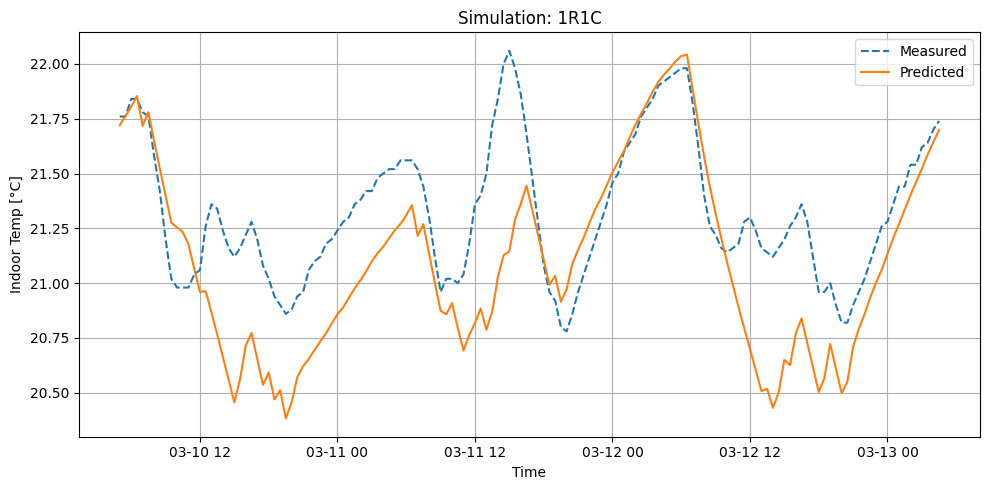

In [24]:
bounds_cs1 = {
        "R_in_a": (0.001, 1),
        "C_in": (1e6, 5e8),
        "Ain": (0.001, 0.3 * cs1_surface_area)
    }
model_1r1c_cs1, parameters_1r1c_cs1, initialization_1r1c_cs1, all_trials_1r1c_cs1 = train_greybox_model(
        train_df=train_cs1,
        model_type="1R1C",
        bounds=bounds_cs1,
        solver_name="ipopt",
        num_trials=10,
        deltaT=1800,
        show_plot=False
    )
last_index = max(model_1r1c_cs1.T_in.index_set())
initialize_validation = {"Tin": model_1r1c_cs1.T_in[last_index]()}

# --- Run Simulation for Testing ---
validation, t_pred_1r1c_cs1, t_true, test_pred = simulate_and_evaluate(
        val_df=test_cs1,
        param_dict=parameters_1r1c_cs1,
        model_type="1R1C",
        initializations=initialize_validation,
        show_plot=True
    )

### 2R2C

[Trial 1] RMSE = 0.2326, Init: {'R_e_a': 0.607937307049537, 'R_in_e': 0.17135359956360424, 'C_in': 33460744.899654478, 'C_e': 474493883.0894133, 'Ain': 28.968995360203706, 'Ae': 24.25211204614572, 'fh': 0.3046137691733707}
 parameters: {'R_in_e': 0.33804861517888596, 'R_e_a': 0.0014642796010812707, 'C_in': 1000237.3254701638, 'C_e': 1000006.2986809004, 'Ain': 0.022188863681936583, 'Ae': 0.001041975189905711, 'fh': 0.03758228897001034, 'Objective': 0.054115272905034165, 'Solve_time': 0.36177897453308105}
[Trial 2] RMSE = 0.2327, Init: {'R_e_a': 0.09857444189237749, 'R_in_e': 0.6845487934856448, 'C_in': 220636094.37606105, 'C_e': 61897079.18754464, 'Ain': 14.855812126427994, 'Ae': 1.0326212449354364, 'fh': 0.9093204020787821}
 parameters: {'R_in_e': 0.3095520689886013, 'R_e_a': 0.0012627181278815197, 'C_in': 1093065.3045626872, 'C_e': 1152361.9449935353, 'Ain': 0.024277253514383448, 'Ae': 0.0010489031581119763, 'fh': 0.04169079867719129, 'Objective': 0.05417049794947289, 'Solve_time': 0.

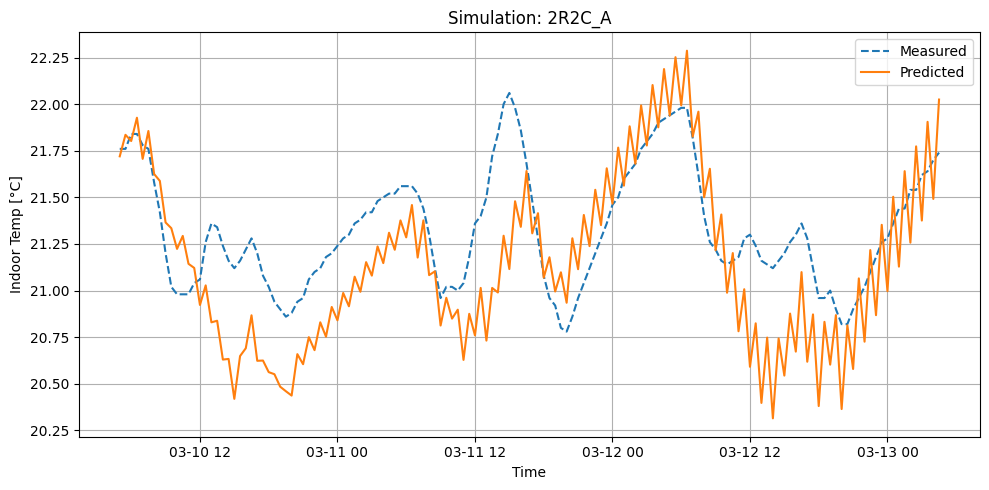

In [25]:
bounds_cs1 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.001, 0.3 * cs1_surface_area),
    "Ae": (0.001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}

model_2r2c_cs1, parameters_2r2c_cs1, initialization_2r2c_cs1, all_trials_2r2c_cs1 = train_greybox_model(
        train_df=train_cs1, model_type="2R2C_A", bounds=bounds_cs1, solver_name="ipopt",
        num_trials=10, deltaT=1800, show_plot=False
)
last_index = max(model_2r2c_cs1.T_in.index_set())
initialize_validation = {"Tin": model_2r2c_cs1.T_in[last_index]()}

# --- Run Simulation for Testing ---
validation, t_pred_2r2c_cs1, t_true, test_pred = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_2r2c_cs1, model_type="2R2C_A",
        initializations=initialize_validation, show_plot=True
    )

[Trial 1] RMSE = 0.6138, Init: {'R_in_e': 0.032397756501047516, 'R_e_a': 0.6367740008525166, 'R_in_a': 0.31504162509525035, 'C_in': 254776774.89118668, 'C_e': 453875670.4891204, 'Ain': 7.4788419452433335, 'Ae': 12.311546652776588, 'fh': 0.7555511385430487}
 parameters: {'R_in_e': 0.034701476728365786, 'R_e_a': 0.0013328232053081267, 'R_in_a': 0.008544745928099716, 'C_in': 254776210.59073523, 'C_e': 453875743.0672603, 'Ain': 29.99999835747999, 'Ae': 29.999964738941735, 'fh': 0.9999999738026647, 'Objective': 0.37676322946674934, 'Solve_time': 0.28116798400878906}
[Trial 2] RMSE = 0.4691, Init: {'R_in_e': 0.22956936732613084, 'R_e_a': 0.0779029299189642, 'R_in_a': 0.29046170146085426, 'C_in': 81449422.3397482, 'C_e': 464919128.51894397, 'Ain': 24.243630574894553, 'Ae': 19.002149354937053, 'fh': 0.8714605901877177}
 parameters: {'R_in_e': 0.0079495369172216, 'R_e_a': 0.9999936215547156, 'R_in_a': 0.006684003530790986, 'C_in': 100591745.00975698, 'C_e': 468081075.1107579, 'Ain': 15.56321442

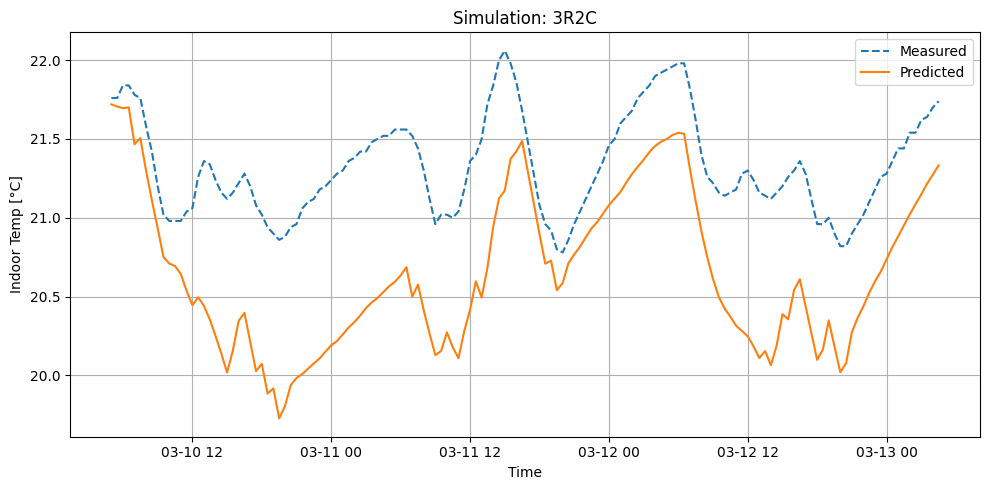

In [26]:
bounds_cs1 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
model_3r2c_cs1, parameters_3r2c_cs1, initialization_3r2c_cs1, all_trials_3r2c_cs1 = train_greybox_model(
        train_df=train_cs1, model_type="3R2C", bounds=bounds_cs1,
        solver_name="ipopt", num_trials=10, deltaT=1800, show_plot=False
    )
last_index = max(model_3r2c_cs1.T_in.index_set())
initialize_validation = {"Tin": model_3r2c_cs1.T_in[last_index]()}

# --- Run Simulation for Testing ---
validation, t_pred_3r2c_cs1, t_true, test_pred = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_3r2c_cs1, model_type="3R2C",
        initializations=initialize_validation, show_plot=True
    )

### 4R3C

[Trial 1] RMSE = 0.5027, Init: {'R_int_in': 0.342384218348158, 'R_in_e': 0.1152465741981079, 'R_e_a': 0.9248442310420056, 'R_in_a': 0.8775846746742191, 'C_int': 129861283.90431961, 'C_in': 330400042.1618485, 'C_e': 408830433.4603664, 'Aint': 16.65606882790271, 'Ain': 15.889564385622359, 'Ae': 7.25564454178446, 'fh_int': 0.09310276780589921, 'fh_in': 0.8972157579533268, 'fh_e': 0.9004180571633305}
 parameters: {'R_int_in': 0.004513830595517428, 'R_in_e': 0.009958008915454087, 'R_e_a': 0.9999867647711895, 'R_in_a': 0.00469082529468546, 'C_int': 216564594.53834718, 'C_in': 158371349.34726208, 'C_e': 199931296.08002475, 'Aint': 29.999992921282825, 'Ain': 16.76400502198947, 'Ae': 29.999987610391724, 'fh_int': 4.806602829323791e-08, 'fh_in': 0.9999999087457732, 'fh_e': 4.318819848600684e-08, 'Objective': 0.25267833052299643, 'Solve_time': 0.7489311695098877}
[Trial 2] RMSE = 0.4300, Init: {'R_int_in': 0.6338352543587215, 'R_in_e': 0.3403517314666033, 'R_e_a': 0.3505111554634356, 'R_in_a': 0.

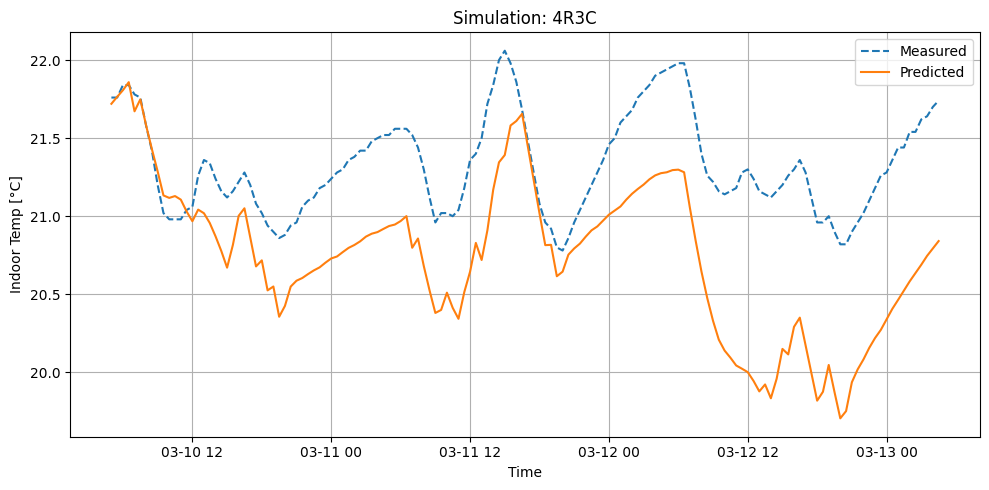

In [27]:
bounds_cs1 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs1_surface_area),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}

model_4r3c_cs1, parameters_4r3c_cs1, initialization_4r3c_cs1, all_trials_4r3c_cs1 = train_greybox_model(
        train_df=train_cs1, model_type="4R3C", bounds=bounds_cs1, solver_name="ipopt",
        num_trials=10, deltaT=1800, show_plot=False
    )
last_index = max(model_4r3c_cs1.T_in.index_set())
initialize_validation = {"Tin": model_4r3c_cs1.T_in[last_index]()}

# --- Run Simulation for Testing ---
validation, t_pred_4r3c_cs1, t_true, test_pred = simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_4r3c_cs1, model_type="4R3C",
        initializations=initialize_validation, show_plot=True
    )


RMSE 1R1C 1R1C: 0.24 °C
RMSE 2R2C 1R1C: 0.23 °C
RMSE 3R2C 1R1C: 0.16 °C
RMSE 4R3C 1R1C: 0.12 °C


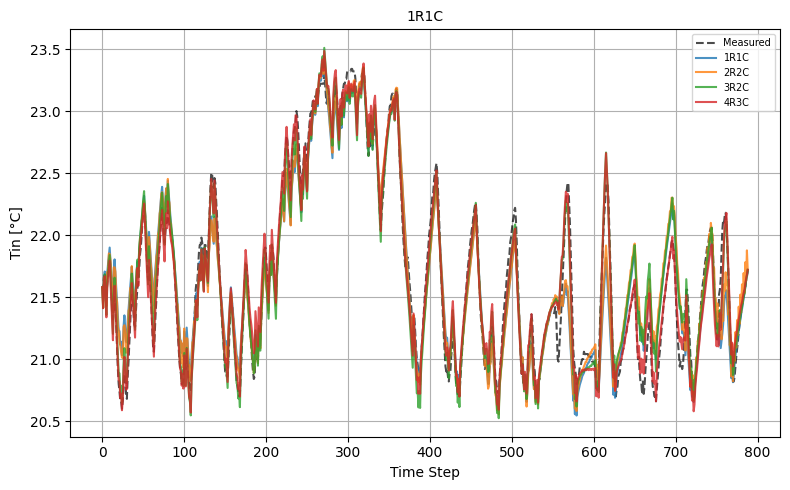

In [28]:
T_model_1r1c = np.array([model_1r1c_cs1.T_in[t]() for t in model_1r1c_cs1.T_in.index_set()])
T_model_2r2c = np.array([model_2r2c_cs1.T_in[t]() for t in model_2r2c_cs1.T_in.index_set()])
T_model_3r2c = np.array([model_3r2c_cs1.T_in[t]() for t in model_3r2c_cs1.T_in.index_set()])
T_model_4r3c = np.array([model_4r3c_cs1.T_in[t]() for t in model_4r3c_cs1.T_in.index_set()])
real_datasets=[train_cs1]
prediction_dataset=[[T_model_1r1c,T_model_2r2c,T_model_3r2c, T_model_4r3c]]
labels = ['1R1C', '2R2C', '3R2C', '4R3C']
plot_model_validation(real_datasets,prediction_dataset,labels, figsize=(8,5))

RMSE 1R1C 1R1C: 0.36 °C
RMSE 2R2C 1R1C: 0.36 °C
RMSE 3R2C 1R1C: 0.74 °C
RMSE 4R3C 1R1C: 0.69 °C


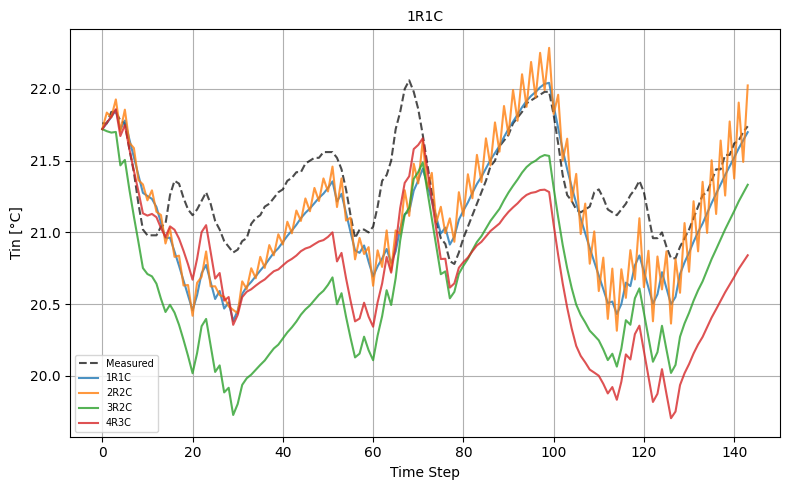

In [29]:
real_datasets=[test_cs1]
prediction_dataset=[[t_pred_1r1c_cs1,t_pred_2r2c_cs1,t_pred_3r2c_cs1, t_pred_4r3c_cs1]]
labels = ['1R1C', '2R2C', '3R2C', '4R3C']
plot_model_validation(real_datasets,prediction_dataset,labels, figsize=(8,5))

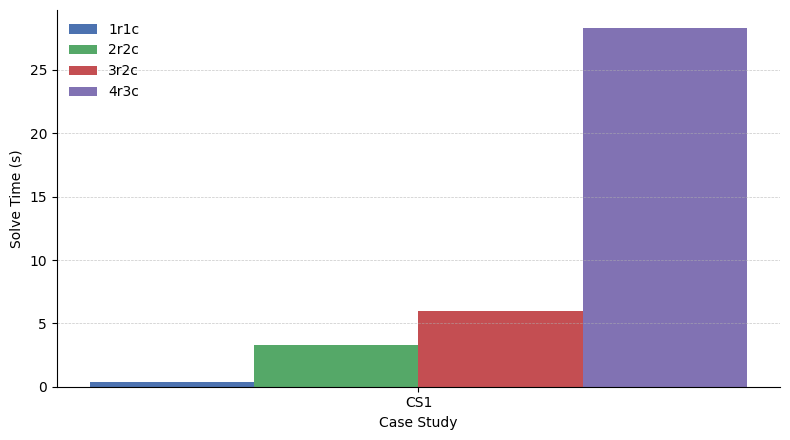

In [30]:
cases = ['CS1']
models = ['1r1c', '2r2c', '3r2c', '4r3c']
solve_times = {
    '1r1c': [all_trials_1r1c_cs1['Solve_time'].sum()],
    '2r2c': [all_trials_2r2c_cs1['Solve_time'].sum()],
    '3r2c': [all_trials_3r2c_cs1['Solve_time'].sum()],
    '4r3c': [all_trials_4r3c_cs1['Solve_time'].sum()],
}

# Bar plot settings
x = np.arange(len(cases))
width = 0.18
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b3']

fig, ax = plt.subplots(figsize=(8, 4.5))

for i, model in enumerate(models):
    ax.bar(x + i * width, solve_times[model], width, label=model, color=colors[i])

# Axis formatting
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(cases)
ax.set_ylabel("Solve Time (s)")
ax.set_xlabel("Case Study")
# ax.set_title("Comparison of Solve Time Across Models and Case Studies", fontsize=13, pad=10)

# Style
ax.legend(frameon=False)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()